# Compañía móvil Megaline

## Objetivo: 

Desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: **smart** o **ultra**.

## Contexto

Se tiene acceso a los datos de comportamiento de los suscriptores que ya se han cambiado a los planes nuevos. Para esta tarea de **clasificación** se debe crear un modelo que escoja el plan correcto. El umbral de exactitud de exactitud del modelos será de 0.75. 

## Descripción de datos

Cada observación en el dataset contiene información del comportamiento mensual sobre un usuario. La información dada es la siguiente:

- сalls — número de llamadas,
- minutes — duración total de la llamada en minutos,
- messages — número de mensajes de texto,
- mb_used — Tráfico de Internet utilizado en MB,
- is_ultra — plan para el mes actual (Ultra - 1, Smart - 0).


## 1. Examinar los datos


In [21]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

df = pd.read_csv('./datasets/users_behavior.csv')


In [22]:
# mostrar información del DataFrame
def info(df):
    display(df.head(10))
    print()
    print(df.info())
    print()
    print(df.describe())
    print()
    print('Duplicated: ',df.duplicated().sum())
    print()
    print('Null values %:')
    print(100*df.isnull().sum()/len(df))

In [23]:
info(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None

             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000

<AxesSubplot: title={'center': 'is_ultra'}, xlabel='is_ultra'>

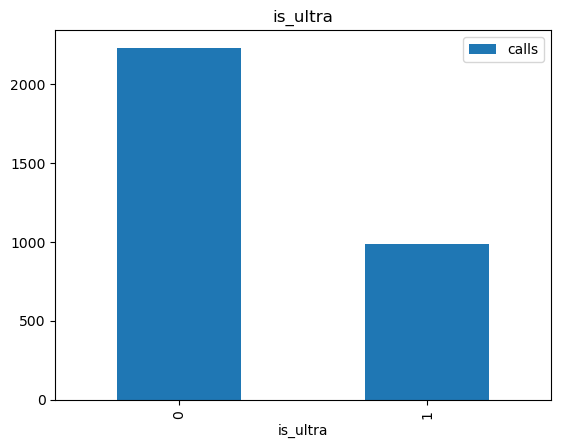

In [24]:
df.groupby('is_ultra').count().plot(kind='bar', y='calls', title='is_ultra')

In [25]:
print('Porcentaje de usuarios en cada plan:')
100*df.groupby('is_ultra')['is_ultra'].count()/len(df)

Porcentaje de usuarios en cada plan:


is_ultra
0    69.352831
1    30.647169
Name: is_ultra, dtype: float64

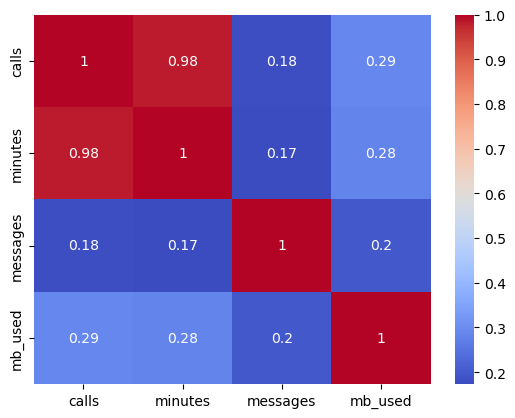

In [26]:
# Matriz de correlación
correlation_matrix = df[[ 'calls','minutes','messages','mb_used']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## 2. Segmenta los datos en un conjunto de entrenamiento, uno de validación y uno de prueba.

In [27]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [28]:
# Dividimos los datos en entrenamiento (60%) y temporal (40%) 
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)

# Dividimos el conjunto temporal en validación (20%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


<div class="alert alert-block alert-info">
<b>

* X: características
* Y: variable objetivo
* X_train, y_train: Conjunto de entrenamiento
* X_val, y_val: Conjunto de validación
* X_test, y_test: Conjunto de prueba

</b> <a class="tocSkip"></a>

## 3. Investiga la calidad de diferentes modelos cambiando los hiperparámetros. Describe brevemente los hallazgos del estudio.

### 3.1 Regresión lineal

In [29]:
# Entrenar el modelo (train)
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones del modelo con el conjunto de validación
predictions_val = model.predict(X_val)

# Raíz cuadrática media  para validación
result_val = mean_squared_error(y_val, predictions_val)**0.5
print("RMSE del modelo de regresión lineal en el conjunto de validación:", round(result_val,4))

# Predicciones final (test)
predictions_test = model.predict(X_test)

# RSME para el conjunto de prueba
result_test = mean_squared_error(y_test, predictions_test)**0.5
print("RMSE del modelo de regresión lineal en el conjunto de prueba:", round(result_test,4))


RMSE del modelo de regresión lineal en el conjunto de validación: 0.4492
RMSE del modelo de regresión lineal en el conjunto de prueba: 0.436


<div class="alert alert-block alert-info">
<b>

El RSME mide la magnitud promedio de los errores entre los valores predichos y los valores reales:

1. Para el conjunto de validación es aproximadamente **0.449** y para el conjunto de prueba, es aproximadamente $0.436$. 
2. Estos resultados sugieren que el modelo de regresión lineal tiene un nivel similar de precisión tanto en el conjunto de datos de validación como en el de prueba, con un rendimiento ligeramente mejor en el conjunto de prueba. 
3. Los valores cercanos de RMSE entre los conjuntos de validación y prueba implican que el modelo se generaliza bien a datos no vistos, lo que indica un buen equilibrio entre sesgo y varianza, sin sobreajuste o subajuste significativo.

</b> <a class="tocSkip"></a>

### 3.2 Regresión logística


In [30]:
# Entrenar el modelo (train)
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
#model = LogisticRegression()
model.fit(X_train, y_train)

# Predicciones del modelo con el conjunto de validación
y_pred_val = model.predict(X_val)
# Métricas de rendimiento  para validación
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)

# Predicciones final (test)
y_pred_test = model.predict(X_test)
# Métricas de rendimiento  final
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

# Imprimir métricas
print(f"Accuracy (Validation): {accuracy_val}")
print(f"Accuracy (Test): {accuracy_test}")
print()
print(f"AUC (Validation): {auc_val}")
print(f"AUC (Test): {auc_test}")
print()
print(f"F1 (Validation): {f1_val}")
print(f"F1 (Test): {f1_test}")

Accuracy (Validation): 0.7402799377916018
Accuracy (Test): 0.7682737169517885

AUC (Validation): 0.5931460699733674
AUC (Test): 0.6353250915750915

F1 (Validation): 0.33466135458167334
F1 (Test): 0.4377358490566038


/tmp/ipykernel_30240/3826389493.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


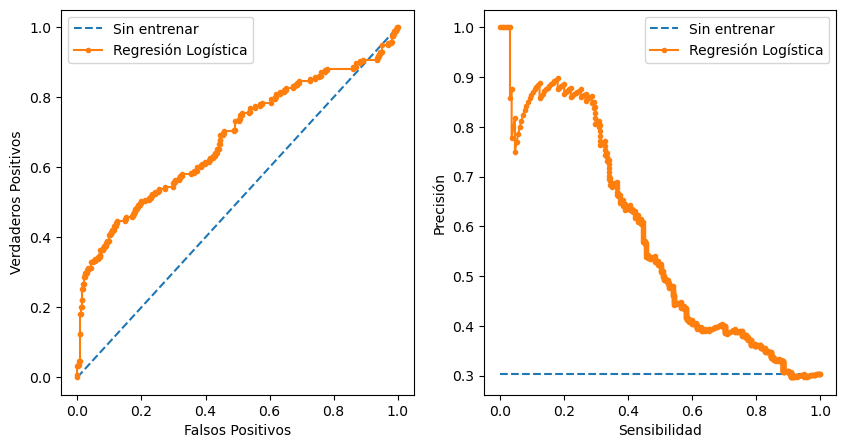

In [31]:
#Generamos un clasificador sin entrenar ,  0 a todo
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
no_train = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(10,5))
plt.title('Test', size = 15)
plt.subplot(1,2,1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Regresión Logística')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.legend()
plt.subplot(1,2,2)
plt.plot([0, 1], [no_train, no_train], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
plt.legend()
plt.show()

/tmp/ipykernel_30240/2398919545.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


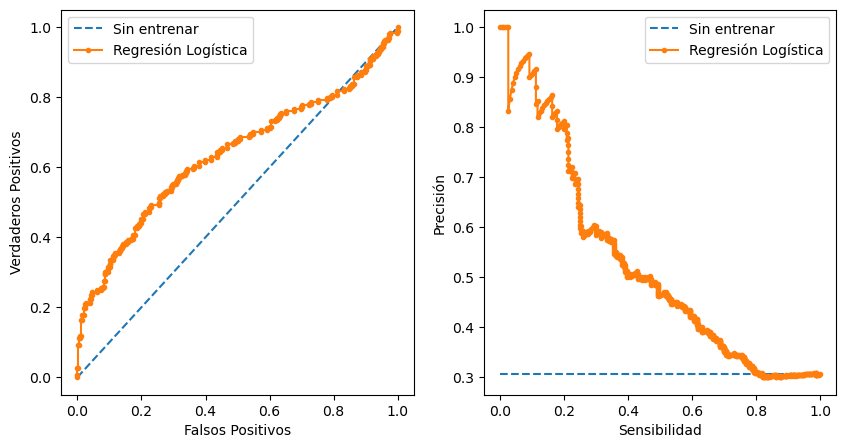

In [32]:
#Generamos un clasificador sin entrenar ,  0 a todo
ns_probs = [0 for _ in range(len(y_val))]
lr_probs = model.predict_proba(X_val)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
no_train = len(y_val[y_val==1]) / len(y_val)

plt.figure(figsize=(10,5))
plt.title('Validation', size = 15)
plt.subplot(1,2,1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Regresión Logística')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.legend()
plt.subplot(1,2,2)
plt.plot([0, 1], [no_train, no_train], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix test')

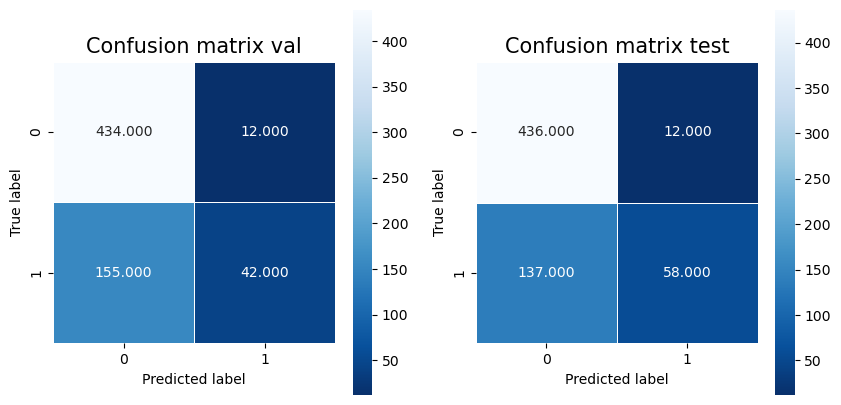

In [33]:

conf_matrix_val = confusion_matrix(y_val, y_pred_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
sns.heatmap(conf_matrix_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix val', size = 15)
plt.subplot(1, 2, 2) 
sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix test', size = 15)

<div class="alert alert-block alert-info">
<b>


* Precisión (Accuracy): La precisión en el conjunto de prueba (76.83%) es ligeramente superior a la del conjunto de validación (74.03%). Esto indica que el modelo generaliza bien en datos no vistos, manteniendo un rendimiento similar o ligeramente mejor.

* Área Bajo la Curva ROC (AUC): Los valores de AUC para ambos conjuntos son relativamente bajos (59.31% para validación y 63.53% para prueba), lo que sugiere que el modelo tiene una capacidad limitada para distinguir entre las clases positivas y negativas. Un AUC más cercano a 1 indicaría un mejor rendimiento del modelo en términos de sensibilidad y especificidad.

* Puntuación F1 (F1 Score): La puntuación F1 es considerablemente baja en ambos conjuntos (33.47% para validación y 43.77% para prueba), lo que indica que el modelo tiene dificultades para equilibrar la precisión y la sensibilidad, especialmente en el conjunto de validación. La puntuación F1 es una medida importante en contextos donde las clases están desbalanceadas o cuando se desea un equilibrio entre la precisión y la sensibilidad.

* Matriz de confusión:

-  Verdaderos Positivos (TP): 42. Estos son los casos en los que el modelo predijo correctamente la clase positiva.
- Verdaderos Negativos (TN): 434. Estos son los casos en los que el modelo predijo correctamente la clase negativa.
- Falsos Positivos (FP): 12. Estos son los casos en los que el modelo predijo incorrectamente la clase negativa como positiva.
- Falsos Negativos (FN): 155. Estos son los casos en los que el modelo predijo incorrectamente la clase positiva como negativa.

### Conclusiones:

Alta Especificidad: El modelo tiene una alta especificidad (TN / (TN + FP) = 434 / (434 + 12)), lo que indica que es muy bueno en identificar los verdaderos negativos. Esto significa que el modelo es efectivo en identificar las instancias que no pertenecen a la clase positiva.

Sensibilidad Mejorable: La sensibilidad (TP / (TP + FN) = 42 / (42 + 155)) es relativamente baja, lo que indica que el modelo tiene dificultades para identificar correctamente todos los verdaderos positivos. Esto sugiere que el modelo podría estar perdiéndose una cantidad significativa de instancias positivas.

Precisión y F1 Score: La precisión (TP / (TP + FP) = 42 / (42 + 12)) y el F1 Score (2 * (Precisión * Sensibilidad) / (Precisión + Sensibilidad)) pueden ser calculados para evaluar más a fondo el rendimiento. Dado el alto número de FN, se puede anticipar que el F1 Score también será mejorable.

Recomendaciones:

Mejorar la Sensibilidad: Considerar técnicas para mejorar la sensibilidad del modelo, como:

- Mejorar el Equilibrio de Clases: Si las clases están desbalanceadas, considerar técnicas de muestreo como SMOTE para el entrenamiento o ajustar los pesos de las clases en el modelo.

- Modelos Alternativos: Considerar probar con diferentes algoritmos de clasificación que puedan ser más adecuados para este conjunto de datos específico, como árboles de decisión, bosques aleatorios, o máquinas de soporte vectorial.

- Revisión de Características: Evaluar la selección de características para asegurar que el modelo tenga acceso a la información más relevante y discriminativa posible.



En resumen, aunque el modelo es efectivo en identificar instancias negativas, hay una oportunidad significativa para mejorar su capacidad de detectar correctamente las instancias positivas. Trabajar en aumentar la sensibilidad del modelo sin sacrificar demasiado la especificidad podría llevar a un mejor equilibrio y rendimiento general.


</b> <a class="tocSkip"></a>

## Muestra balanceada


Accuracy (Validation): 0.6278026905829597
Accuracy (Test): 0.6300448430493274

AUC (Validation): 0.6251385278768461
AUC (Test): 0.6331279945242985

F1 (Validation): 0.5921375921375921
F1 (Test): 0.6389496717724288


Text(0.5, 1.0, 'Confusion matrix test')

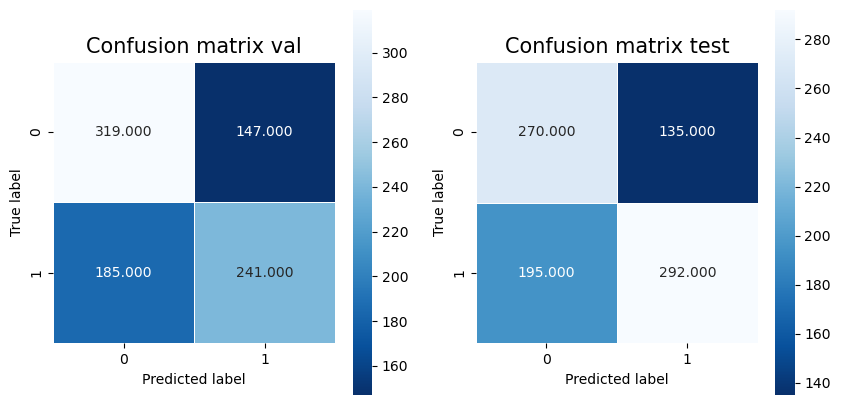

In [34]:
smote = SMOTE(random_state=42)
features_balanced, target_balanced = smote.fit_resample(features, target)
X_train, X_temp, y_train, y_temp = train_test_split(features_balanced, target_balanced, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
print(f"Accuracy (Validation): {accuracy_val}")
print(f"Accuracy (Test): {accuracy_test}")
print()
print(f"AUC (Validation): {auc_val}")
print(f"AUC (Test): {auc_test}")
print()
print(f"F1 (Validation): {f1_val}")
print(f"F1 (Test): {f1_test}")
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
sns.heatmap(conf_matrix_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix val', size = 15)
plt.subplot(1, 2, 2) 
sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix test', size = 15)

<div class="alert alert-block alert-info">
<b>

* Conclusión Balance de Muestra: 

El uso de SMOTE para balancear las muestras ha permitido que el modelo se entrene en un conjunto de datos donde las clases están equilibradas, lo cual es crucial para mejorar el rendimiento del modelo en clases minoritarias. Sin embargo, los resultados sugieren que, aunque el balanceo de la muestra es un paso importante, el modelo de regresión logística utilizado no es  el más adecuado.

</b> <a class="tocSkip"></a>

### 3.3 Arboles de decisión

In [35]:
# Inicializar el clasificador de árbol de decisión
clf = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train, y_train)

# Realizar predicciones en los conjuntos de prueba y validación
y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)


# Calcular métricas de evaluación para el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
f1_test = f1_score(y_test, y_pred_test)

# Calcular métricas de evaluación para el conjunto de validación
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_score_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
f1_val = f1_score(y_val, y_pred_val)

 #Imprimir los resultados
print(f"Test - Accuracy: {accuracy_test}, AUC: {auc_score_test}, F1 Score: {f1_test}")
print(f"Validation  - Accuracy: {accuracy_val}, AUC: {auc_score_val}, F1 Score: {f1_val}")


Test - Accuracy: 0.7298206278026906, AUC: 0.7307399802266331, F1 Score: 0.7444326617179214
Validation  - Accuracy: 0.7163677130044843, AUC: 0.7164510669165205, F1 Score: 0.7075144508670521


<div class="alert alert-block alert-info">
<b>

- Exactitud (Accuracy): El modelo alcanzó una exactitud del 72.98%. Esto indica que el modelo es capaz de predecir correctamente el 72.98% de las veces en el conjunto de prueba. 

- AUC (Área bajo la curva ROC): El valor de AUC es de 0.7307, lo cual es ligeramente superior a la exactitud. Un AUC de 0.7307 sugiere que el modelo tiene una buena capacidad de discriminación, siendo capaz de diferenciar entre las clases positivas y negativas con una probabilidad del 73.07%.

- Puntuación F1 (F1 Score): La puntuación F1 es de 0.7444,  Este valor indica que el modelo tiene un buen equilibrio entre la precisión (la proporción de identificaciones positivas reales entre todas las identificaciones positivas) y la sensibilidad (la proporción de positivos reales que fueron identificados correctamente), con un ligero énfasis en la sensibilidad.

### Conclusiones:

El modelo de árbol de decisión muestra un rendimiento general bueno en el conjunto de prueba, con métricas de evaluación que indican una capacidad razonablemente buena para clasificar correctamente las instancias y distinguir entre las clases.

Equilibrio entre Precisión y Sensibilidad: La puntuación F1 superior a la exactitud y al AUC sugiere que el modelo ha logrado un buen equilibrio entre precisión y sensibilidad, lo cual es particularmente importante en contextos donde tanto los falsos positivos como los falsos negativos tienen consecuencias significativas.

Recomendaciones

Explorar la optimización de hiperparámetros, como la profundidad máxima del árbol, el número mínimo de muestras requeridas para dividir un nodo, o la implementación de técnicas de ensamblaje como Random Forest.

</b> <a class="tocSkip"></a>

### 3.3 Arboles aleatorios

In [36]:
# Inicializar el clasificador de Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

# Entrenar el modelo con el conjunto de entrenamiento
rf_clf.fit(X_train, y_train)

# Realizar predicciones en los conjuntos de prueba y validación
y_pred_test = rf_clf.predict(X_test)
y_pred_val = rf_clf.predict(X_val)


# Calcular métricas de evaluación para el conjunto de validación
accuracy_val = accuracy_score(y_val, y_pred_val)
auc_score_val = roc_auc_score(y_val, rf_clf.predict_proba(X_val)[:, 1])
f1_val = f1_score(y_val, y_pred_val)

# Imprimir los resultados
print(f"Test - Accuracy: {accuracy_test}, AUC: {auc_score_test}, F1 Score: {f1_test}")
print(f"Validation - Accuracy: {accuracy_val}, AUC: {auc_score_val}, F1 Score: {f1_val}")


Test - Accuracy: 0.7298206278026906, AUC: 0.7307399802266331, F1 Score: 0.7444326617179214
Validation - Accuracy: 0.7522421524663677, AUC: 0.8314896532269439, F1 Score: 0.7247820672478208


<div class="alert alert-block alert-info">
<b>

Conjunto de prueba:

- Exactitud (Accuracy): 72.98%
- AUC (Área bajo la curva ROC): 0.7307
- Puntuación F1 (F1 Score): 0.7444

Conjunto de Validación:

- Exactitud (Accuracy): 75.22%
- AUC (Área bajo la curva ROC): 0.8315
- Puntuación F1 (F1 Score): 0.7248


El modelo de Random Forest muestra una mejora en la exactitud y el AUC en el conjunto de validación en comparación con el conjunto de prueba. Esto indica que el modelo es capaz de generalizar bien y proporciona una buena capacidad de discriminación entre las clases, especialmente notable en el aumento del AUC en el conjunto de validación.

A pesar de la mejora en la exactitud y el AUC, la puntuación F1 disminuye ligeramente en el conjunto de validación. Esto sugiere que, aunque el modelo es más preciso y mejor en distinguir entre clases, puede haber un desequilibrio entre la precisión y la sensibilidad, posiblemente debido a una distribución desigual de las clases en el conjunto de validación.

La mejora en el rendimiento en el conjunto de validación sugiere que el modelo de Random Forest está generalizando bien a nuevos datos. Esto es un indicativo positivo de que el modelo no está sobreajustado al conjunto de entrenamiento.

Recomendaciones: 

Los resultados indican que hay espacio para la optimización de hiperparámetros para mejorar aún más el rendimiento del modelo, especialmente para equilibrar la puntuación F1. Experimentar con el número de árboles (n_estimators), la profundidad máxima de los árboles (max_depth), y otros parámetros podría resultar en mejoras significativas.



</b> <a class="tocSkip"></a>


<div class="alert alert-block alert-info">
<b>

Conclusiones

- El modelo de regresión lineal muestra un buen equilibrio entre sesgo y varianza, con un rendimiento similar en los conjuntos de validación y prueba.

- El modelo de regresión logística tiene una alta especificidad pero una sensibilidad mejorable, lo que sugiere que hay oportunidades para mejorar la capacidad del modelo para detectar instancias positivas.

- El modelo de árbol de decisión muestra un buen equilibrio entre precisión y sensibilidad, con una puntuación F1 superior a la exactitud y al AUC.

- El modelo de Random Forest mejora la exactitud y el AUC en el conjunto de validación, lo que sugiere una buena generalización a nuevos datos. Sin embargo, la puntuación F1 disminuye ligeramente, lo que indica un desequilibrio entre precisión y sensibilidad.

En general, los modelos de árbol de decisión y Random Forest muestran un buen rendimiento en términos de equilibrio entre precisión y sensibilidad, con el modelo de Random Forest mostrando una mejor capacidad de generalización a nuevos datos. 


</b> <a class="tocSkip"></a>



## 4. Mejora de hiperparámetros

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) permite encontrar los mejores hiperparámetros para un modelo. Se puede utilizar para optimizar los hiperparámetros de los modelos de regresión logística, árboles de decisión y bosques aleatorios.


In [37]:
# Regresión Logística
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] 
}
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
lr_grid_search_best_parameters = grid_search.best_params_
print("Mejores hiperparámetros:", lr_grid_search_best_parameters)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores hiperparámetros: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [38]:
# DecisionTree
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
dt_grid_search_best_parameters = grid_search.best_params_

print("Mejores hiperparámetros:", dt_grid_search_best_parameters)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_

In [39]:
# RandomForest
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Inicializar el modelo y GridSearchCV
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_model = grid_search.best_estimator_
rf_grid_search_best_parameters = grid_search.best_params_

print("Mejores parámetros:", rf_grid_search_best_parameters)
print("Mejor modelo:", best_model)

# Opcional: Evaluar el mejor modelo en el conjunto de datos de prueba
# Esto podría incluir calcular la precisión, la matriz de confusión, etc.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  

In [40]:

# Best parameters (example values, replace with your optimized parameters)
best_params_rf = rf_grid_search_best_parameters

best_params_dt = dt_grid_search_best_parameters

best_params_lr = lr_grid_search_best_parameters


# Instantiate models with best parameters
models = {
    "Random Forest": RandomForestClassifier(**best_params_rf),
    "Decision Tree": DecisionTreeClassifier(**best_params_dt),
    "Logistic Regression": LogisticRegression(**best_params_lr)
}

# Fit models and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    #print("Confusion Matrix:")
    #print(confusion_matrix(y_test, y_pred))
    #print("Classification Report:")
    #print(classification_report(y_test, y_pred))
    print("-" * 50)

Model: Random Forest
Accuracy: 0.7690582959641256
--------------------------------------------------
Model: Decision Tree
Accuracy: 0.7197309417040358
--------------------------------------------------
Model: Logistic Regression
Accuracy: 0.6278026905829597
--------------------------------------------------


<div class="alert alert-block alert-info">
<b>

Conclusiones

la evaluación de los tres modelos (bosque aleatorio, árbol de decisión y regresión logística) en un conjunto de datos de prueba, a continuación se presentan algunas conclusiones y posibles próximos pasos:

- Rendimiento del bosque aleatorio: el modelo de bosque aleatorio logró la mayor precisión entre los tres modelos con aproximadamente un 77.69%. 
- Rendimiento del árbol de decisión: el modelo del árbol de decisión mostró una precisión moderada de aproximadamente el 73.54%. Si bien son más sencillos y rápidos de entrenar que los bosques aleatorios, los árboles de decisión son más propensos a sobreajustarse, especialmente con conjuntos de datos complejos. Esta podría ser la razón por la que no funcionó tan bien como el modelo Random Forest.

- Rendimiento de la regresión logística: el modelo de regresión logística tuvo la precisión más baja con aproximadamente 62.68%. Esto indica que la relación del conjunto de datos entre las características y la variable objetivo podría no ser lineal, o que el modelo podría requerir un mayor ajuste de parámetros.

Ingeniería de funciones: investigue si la creación de nuevas funciones o la transformación de las existentes podría mejorar el rendimiento del modelo, especialmente para la regresión logística.

Recomendaciones:

Explore otros modelos como Support Vector Machines (SVM) que podrían ser más adecuados para estos datos.

</b> <a class="tocSkip"></a>